# Spotify Track Recommender System with LightGCN

## Install and import necessary libraries

Before proceeding, we need to install and import all of the necessary libraries. T

In [ ]:
## First, we need to install various libraries that do not come pre-installed

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html

!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html

!pip install torch-geometric

!pip install umap-learn

Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3938493 sha256=aef7528526298382d93bf928a1e13e645099b72271104a394af0599c06569177
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=2729581 sha256=c6d5f3f935dfcd7fe7bdd2b04a0a84b440e7b98d35ecc9c088ec8c6177c4a7f5
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built t

In [ ]:
# General libraries

import json

from pathlib import Path as Data_Path

import os

from os.path import isfile, join

import pickle

import random
import sys



import numpy as np

import networkx as nx

import pandas as pd

from sklearn.metrics import f1_score, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline



from tqdm.notebook import tqdm

In [ ]:
# Import relevant ML libraries

from typing import Optional, Union



import torch

from torch import Tensor

import torch.nn as nn

from torch.nn import Embedding, ModuleList, Linear

import torch.nn.functional as F



import torch_geometric

import torch_geometric.nn as pyg_nn

from torch_geometric.data import Data

from torch_geometric.transforms import RandomLinkSplit

from torch.nn.modules.loss import _Loss



from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv

from torch_geometric.typing import Adj, OptTensor, SparseTensor



print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.4.0; Torch-cuda version: 12.3; Torch Geometric version: 2.6.1.


In [ ]:
print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.4.0; Torch-cuda version: 12.3; Torch Geometric version: 2.6.1.


We also set a random seed so that our work is reproducible!

In [ ]:
# set the seed for reproducibility

seed = 224

torch.manual_seed(seed)

np.random.seed(seed)

random.seed(seed)

## Loading and processing data

As mentioned in the beginning, the data that we are going to use comes from the Spotify Million Playlist Dataset. This data is available at the following [link](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge). This data contains a million Spotify playlists (as the name suggests) created between January 2010 and October 2017 as well as all of thier tracks. Unfortunately, due to copyright restrictions, we can't host the data ourselves in this Colab, but it is free to make an account to get access to the data!



One additional note about the data: a million playlists, each with all of their songs and metadata, take up a lot of space. The full dataset folder is around 34 GB and contians 1,000 JSON files each roughly 34 MB and containing 1,000 playlists.



For this tutorial, we don't need to use all of the data, so we restrict our attention to just the first 50 files. Depending on your Colab instance -- in our experience, both system and GPU RAM can be limiting factors -- this might be too many files, in which case you're welcome to try it on a smaller graph. In that case, we recommend restricting to the first 30 files.

Once you have your drive loaded, you can navigate to the relevant directory as follows.

In [ ]:
MAIN_DIR = "/kaggle/input/spotify-playlist-data/data"

DATA_DIR = "/kaggle/input/spotify-playlist-data/data"

os.chdir(MAIN_DIR)

Before proceeding, we will visualize an example playlist to give you a sense of how the data is structured.

In [ ]:
with open(f"{DATA_DIR}/{os.listdir(DATA_DIR)[0]}") as jf:

  example_file = json.load(jf)


print(example_file['playlists'][0])

{'name': 'coctel', 'collaborative': 'false', 'pid': 35000, 'modified_at': 1435881600, 'num_tracks': 27, 'num_albums': 24, 'num_followers': 1, 'tracks': [{'pos': 0, 'artist_name': 'Marian Hill', 'track_uri': 'spotify:track:2Ag3LUfgpN6ymEMwDOqKdg', 'artist_uri': 'spotify:artist:1xHQO9GJIW9OXHxGBISYc5', 'track_name': 'Lovit', 'album_uri': 'spotify:album:4GgwHp794AzZkv2hh8geZu', 'duration_ms': 173013, 'album_name': 'Sway'}, {'pos': 1, 'artist_name': 'Melody Gardot', 'track_uri': 'spotify:track:6r1GKz2EZ5DsKGKnWT7uWp', 'artist_uri': 'spotify:artist:2P1puQXmG48EVLBrHbum1J', 'track_name': 'Goodnite', 'album_uri': 'spotify:album:5udX7aCoYd3VZQuKNpEs0Y', 'duration_ms': 184160, 'album_name': 'Worrisome Heart'}, {'pos': 2, 'artist_name': 'The xx', 'track_uri': 'spotify:track:2SMn57cBVxoD4TArscpovk', 'artist_uri': 'spotify:artist:3iOvXCl6edW5Um0fXEBRXy', 'track_name': 'Islands', 'album_uri': 'spotify:album:2nXJkqkS1tIKIyhBcFMmwz', 'duration_ms': 160720, 'album_name': 'xx'}, {'pos': 3, 'artist_name

Now let's get ready to load in our data. First, we define a few simple, helfpul classes.

In [ ]:
"""

Here we define classes for the data that we are going to load. The data is stored in JSON files, each

which contain playlists, which themselves contain tracks. Thus, we define three classes:

  Track       --> contains information for a specific track (its id, name, etc.)

  Playlist    --> contains information for a specific playlist (its id, name, etc. as well as a list of Tracks)

  JSONFile    --> contains the loaded json file and stores a dictionary of all of the Playlists



Note: if we were to use the artist information, we could make an Artist class

"""



class Track:

  """

  Simple class for a track, containing its attributes:

    1. URI (a unique id)

    2. Name

    3. Artist info (URI and name)

    4. Parent playlist

  """



  def __init__(self, track_dict, playlist):

    self.uri = track_dict["track_uri"]

    self.name = track_dict["track_name"]

    self.artist_uri = track_dict["artist_uri"]

    self.artist_name = track_dict["artist_name"]

    self.playlist = playlist



  def __str__(self):

    return f"Track {self.uri} called {self.name} by {self.artist_uri} ({self.artist_name}) in playlist {self.playlist}."



  def __repr__(self):

    return f"Track {self.uri}"



class Playlist:

  """

  Simple class for a playlist, containing its attributes:

    1. Name (playlist and its associated index)

    2. Title (playlist title in the Spotify dataset)

    3. Loaded dictionary from the raw json for the playlist

    4. Dictionary of tracks (track_uri : Track), populated by .load_tracks()

    5. List of artists uris

  """



  def __init__(self, json_data, index):



    self.name = f"playlist_{index}"

    self.title = json_data["name"]

    self.data = json_data



    self.tracks = {}

    self.artists = []



  def load_tracks(self):

    """ Call this function to load all of the tracks in the json data for the playlist."""



    tracks_list = self.data["tracks"]

    self.tracks = {x["track_uri"] : Track(x, self.name) for x in tracks_list}

    self.artists = [x["artist_uri"] for x in tracks_list]



  def __str__(self):

    return f"Playlist {self.name} with {len(self.tracks)} tracks loaded."



  def __repr__(self):

    return f"Playlist {self.name}"



class JSONFile:

  """

  Simple class for a JSON file, containing its attributes:

    1. File Name

    2. Index to begin numbering playlists at

    3. Loaded dictionary from the raw json for the full file

    4. Dictionary of playlists (name : Playlist), populated by .process_file()

  """



  def __init__(self, data_path, file_name, start_index):



    self.file_name = file_name

    self.start_index = start_index



    with open(join(data_path, file_name)) as json_file:

      json_data = json.load(json_file)

    self.data = json_data



    self.playlists = {}



  def process_file(self):

    """ Call this function to load all of the playlists in the json data."""



    for i, playlist_json in enumerate(self.data["playlists"]):

      playlist = Playlist(playlist_json, self.start_index + i)

      playlist.load_tracks()

      self.playlists[playlist.name] = playlist



  def __str__(self):

    return f"JSON {self.file_name} has {len(self.playlists)} playlists loaded."



  def __repr__(self):

    return self.file_name


Now we're ready to begin loading the data!



Note: by default, we will use 50 files. Depending on your coding set-up and computational resources, you may want to use more or less. Many of our models were authored and run in a Colab+ instance with GPU and High-RAM. However, we found no problem running all of our models in a standard Colab instance with GPU support.

In [ ]:
DATA_PATH = "/kaggle/input/spotify-playlist-data/data"

N_FILES_TO_USE = 50


file_names = sorted(os.listdir(DATA_PATH))

file_names_to_use = file_names[:N_FILES_TO_USE]



n_playlists = 0



# load each json file, and store it in a list of files

JSONs = []

for file_name in tqdm(file_names_to_use, desc='Files processed: ', unit='files', total=len(file_names_to_use)):

  json_file = JSONFile(DATA_PATH, file_name, n_playlists)

  json_file.process_file()

  n_playlists += len(json_file.playlists)

  JSONs.append(json_file)

Files processed:   0%|          | 0/50 [00:00<?, ?files/s]

In [ ]:
playlist_data = {}

playlists = []

tracks = []



# build list of all unique playlists, tracks

for json_file in tqdm(JSONs):

  playlists += [p.name for p in json_file.playlists.values()]

  tracks += [track.uri for playlist in json_file.playlists.values() for track in list(playlist.tracks.values())]

  playlist_data = playlist_data | json_file.playlists

  0%|          | 0/50 [00:00<?, ?it/s]

Having read in the data, we can now make a graph out of it. We choose to make the playlists and songs nodes and the edes beween them correspond to whether on not a playlist contains a given track.

In [ ]:
## create graph from these lists



# adding nodes

G = nx.Graph()

G.add_nodes_from([

    (p, {'name':p, "node_type" : "playlist"}) for p in playlists

])

G.add_nodes_from([

    (t, {'name':t, "node_type" : "track"}) for t in tracks

])



# adding edges

edge_list = []

for p_name, playlist in playlist_data.items():

  edge_list += [(p_name, t) for t in playlist.tracks]

G.add_edges_from(edge_list)



print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 507016 . Num edges: 3303932


We will need to take a subgraph of this data, as this is too big. One reasonable solution is to look at a k-core where each node $v$ must have degree of k, i.e., $\text{deg}(v) \geq k$. This substnatially reduces the set of nodes we look at while still maintaing a dense, connected subgraph structure.



A similar note as above: you may want to change this kcore parameter depending on your computational resources and the number of data files you are using.

In [ ]:
kcore = 30

G = nx.k_core(G, kcore)

save_path = os.path.join("/kaggle/working/", f"{kcore}core_first_{N_FILES_TO_USE}.pkl")
pickle.dump(G, open(save_path, "wb"))

#pickle.dump(G, open(f"{kcore}core_first_{N_FILES_TO_USE}.pkl", "wb"))

print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 35300 . Num edges: 1606690


## Visualizing our graph

Now that we've built our graph, we can collect a random sample of nodes and then graph the largest connected component of that sample. The resulting node-induced subgraph will allow us to visualize a small fraction of the densely connected k-core graph. In the graphs below, the blue nodes represent playlists, while the red nodes represent tracks. As expected, there are no edges between any two playlist nodes or any two track nodes, but there are edges between tracks and playlists. An edge between a track and a playlist indicates membership of the track in that playlist, such that any two songs in the same playlist are 2 hops away and any two playlists that share a song are 2 hops away. The bi-partite nature of the graph can be clearly visualized in the third visualization, which shows a subgraph of the larger subgraph.

In [ ]:
# Make a large subgraph

random.seed(seed)

rand_nodes_lg = random.sample(list(G.nodes()), 2000)

sub_G_lg = G.subgraph(rand_nodes_lg)

largest_cc_lg = max(nx.connected_components(sub_G_lg.to_undirected()), key=len)

sub_G_lg = nx.Graph(sub_G_lg.subgraph(largest_cc_lg))

print('Large subgraph Num nodes:', sub_G_lg.number_of_nodes(),

      '. Num edges:', sub_G_lg.number_of_edges())

# Make a smaller subgraph from the larger one

rand_nodes_sm = random.sample(list(sub_G_lg.nodes()), 400)

sub_G_sm = sub_G_lg.subgraph(rand_nodes_sm)

largest_cc_sm = max(nx.connected_components(sub_G_sm.to_undirected()), key=len)

sub_G_sm = nx.Graph(sub_G_sm.subgraph(largest_cc_sm))

print('Small subgraph Num nodes:', sub_G_sm.number_of_nodes(),

      '. Num edges:', sub_G_sm.number_of_edges())

Large subgraph Num nodes: 1846 . Num edges: 4792
Small subgraph Num nodes: 186 . Num edges: 208


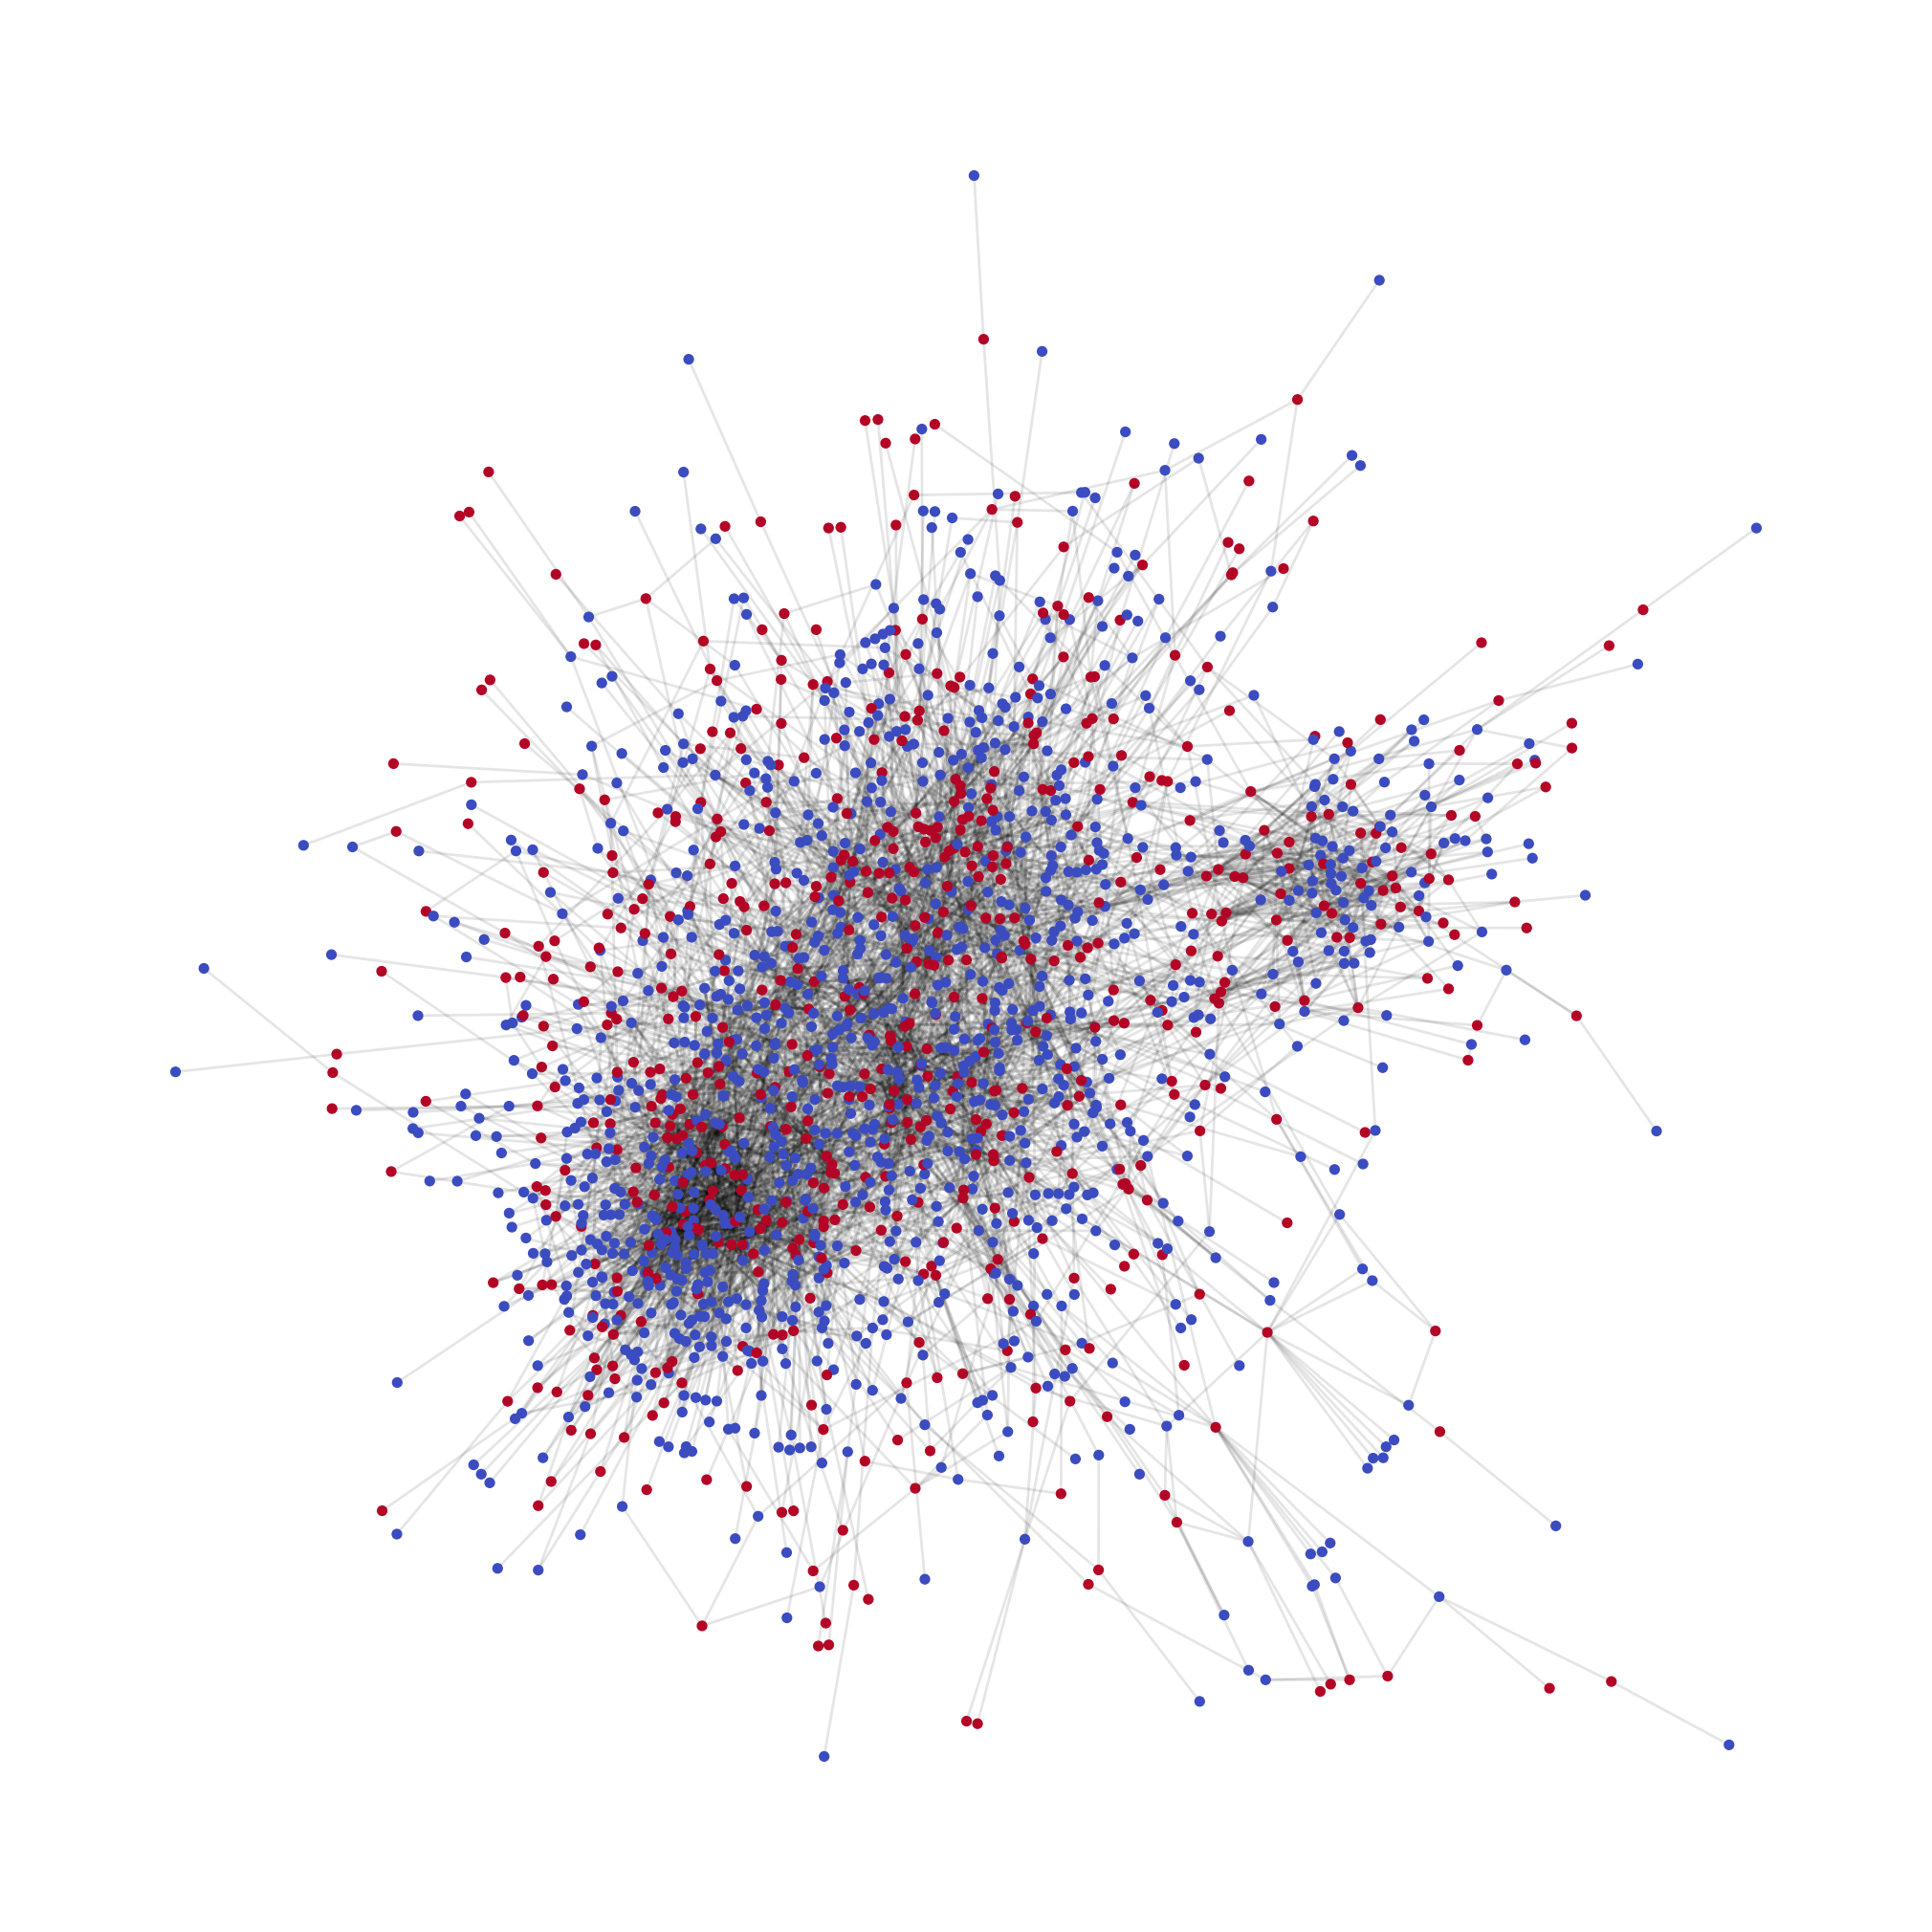

In [ ]:
# Graph the large subgraph

color_map = {"playlist": 0, "track": 1}

node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_lg.nodes(data=True)]

plt.figure(figsize=(20,20))

nx.draw(sub_G_lg,

        cmap=plt.get_cmap('coolwarm'),

        node_color=node_color,

        node_size = 50,

        width = 2,

        edge_color=(0, 0, 0, 0.1))

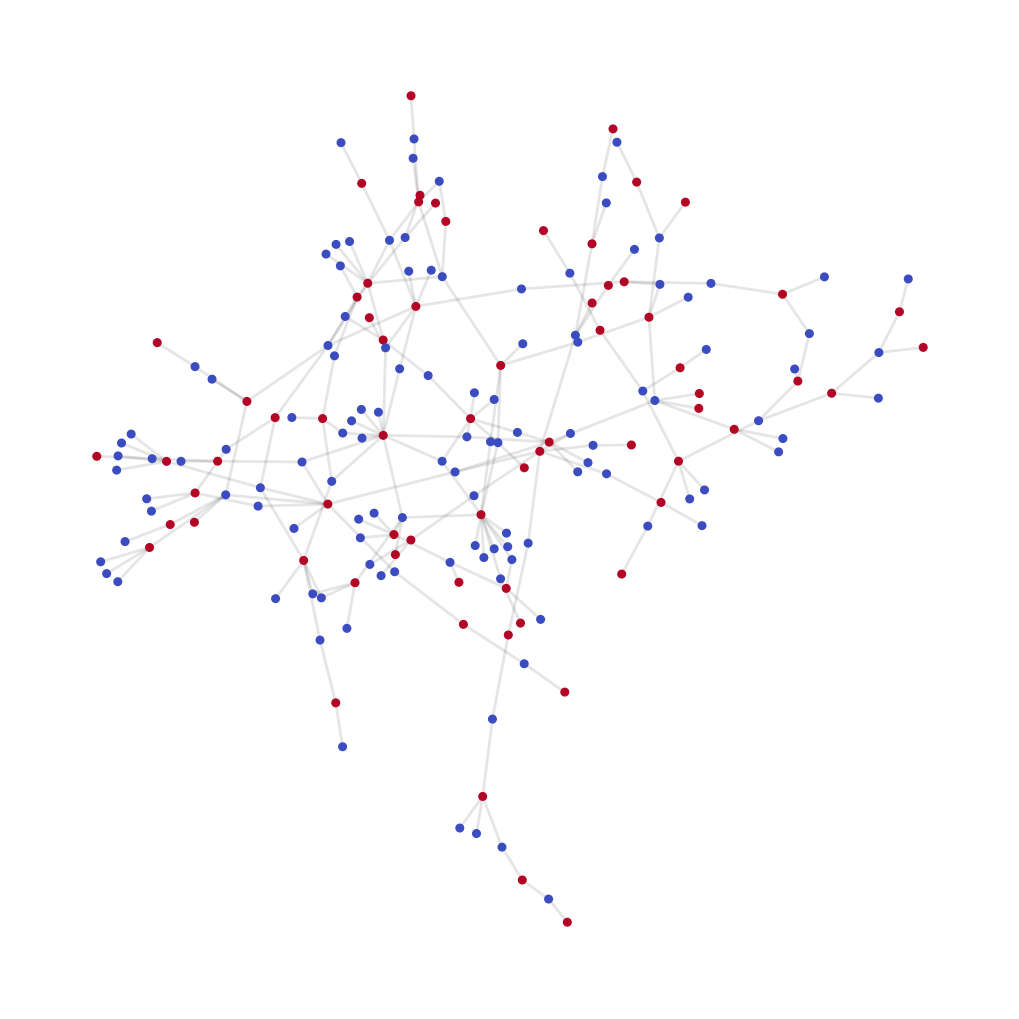

In [ ]:
# Graph the subgraph of the small subgraph

color_map = {"playlist": 0, "track": 1}

node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_sm.nodes(data=True)]

plt.figure(figsize=(10,10))

nx.draw(sub_G_sm,

        cmap=plt.get_cmap('coolwarm'),

        node_color=node_color,

        node_size = 30,

        width = 2,

        edge_color=(0, 0, 0, 0.1))

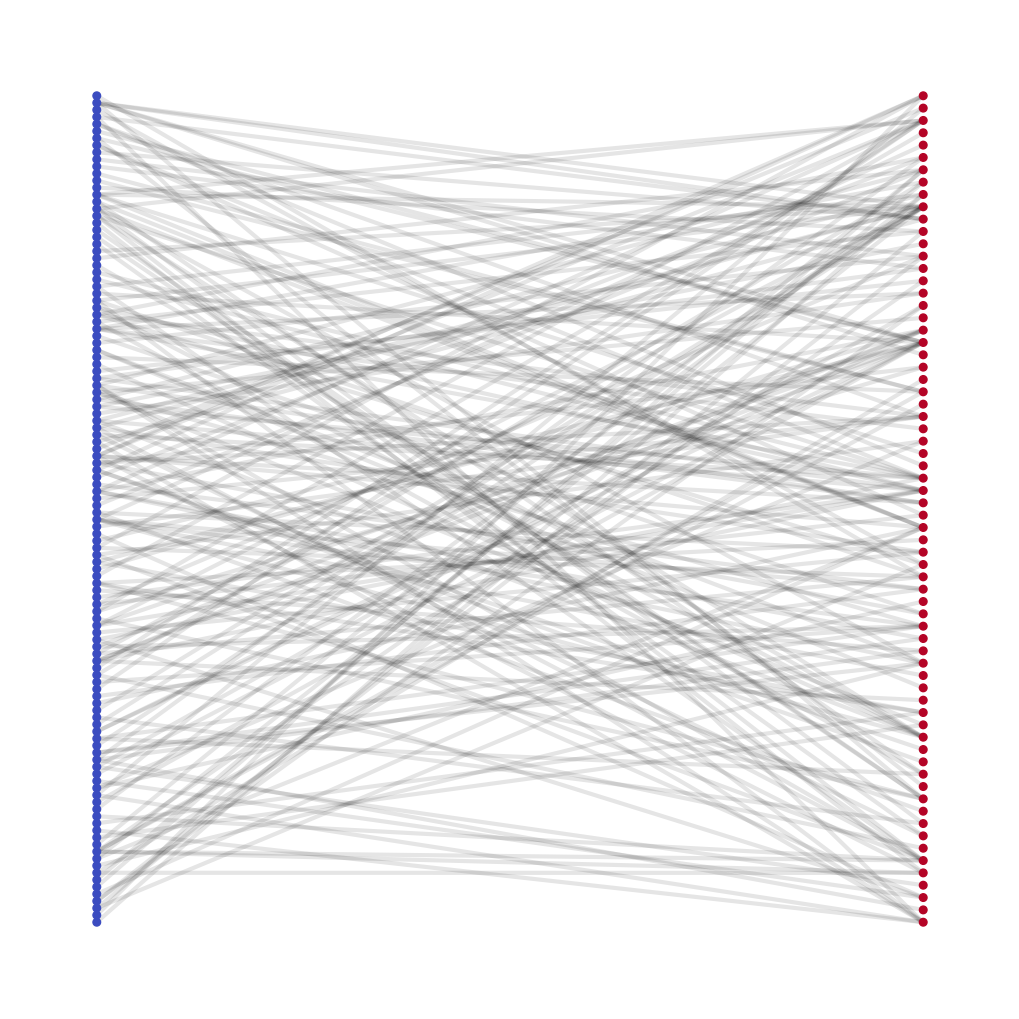

In [ ]:
# Show the smaller subgraph as bipartite

top = nx.bipartite.sets(sub_G_sm)[0]

pos = nx.bipartite_layout(sub_G_sm, top)

plt.figure(figsize=(10,10))

nx.draw(sub_G_sm,

        pos=pos,

        cmap=plt.get_cmap('coolwarm'),

        node_color=node_color,

        node_size = 30,

        width = 3,

        edge_color=(0, 0, 0, 0.1))

Constructing a graph dataset

In order to use our graph with the graph. machine learning packages we installed, we need to do a bit of processing of the graph first.

In [ ]:
# Note if you've already generated the graph above, you can skip those steps, and simply run set reload to True!

reload = False

if reload:

  G = pickle.load(open("30core_first_50.pkl", "rb"))

print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 35300 . Num edges: 1606690


In [ ]:
n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()



# by sorting them we get an ordering playlist1, ..., playlistN, track1, ..., trackN

sorted_nodes = sorted(list(G.nodes()))



# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors

node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))

id2node = dict(zip(np.arange(n_nodes), sorted_nodes))



G = nx.relabel_nodes(G, node2id)



# also keep track of how many playlists, tracks we have

playlists_idx = [i for i, v in enumerate(node2id.keys()) if "playlist" in v]

tracks_idx = [i for i, v in enumerate(node2id.keys()) if "track" in v]



n_playlists = np.max(playlists_idx) + 1

n_tracks = n_nodes - n_playlists



n_playlists, n_tracks

(22874, 12426)

When training a machine learning model, it's important to evaluate its performance on data that the model hasn't seen before to ensure its generalizability to unseen data. A train/validation/test split is used to achieve this by dividing the dataset into three sets: the training set, used to train the model; the validation set, used to tune the model's hyperparameters and prevent overfitting; and the test set, used to evaluate the model's performance on unseen data. We use a 70%-15%-15% split.



How does it work to split a graph? There is an extremely useful PyG method `RandomLinkSplit`, which will help us with that. This function works by randomly removing a specified percentage of the edges in the graph. The split is performed such that the training split doesn't include edges in the validation and test splits; and the validation split doesn't include edges in the test split. Also, since we plan to implement our own negative samplign algorithm we set add_negative_train_samples and neg_sampling_ratio to zero.

In [ ]:
# turn the graph into a torch_geometric Data object


num_nodes = n_playlists +  n_tracks
num_nodes = (num_nodes, num_nodes)

edge_idx = torch.LongTensor(np.array(G.edges()).T)

graph_data = Data(edge_index = edge_idx, num_nodes = num_nodes)


Replaced RandomLinkSplit with a manual stratified split using sklearn.train_test_split. This introduced custom logic for negative sampling using the sample_negative_edges function. Relied heavily on custom tensor manipulations for creating edge masks and sampling edges.

A CUDA error occurred during the negative sampling process. The error indicates a device-side assertion failure due to operations on a flattened mask tensor. This suggests an issue in the logic for generating or indexing negative samples, potentially due to mismatched dimensions in tensors and incorrect assumptions about node or edge indices.

A mismatch in Edge Counts was resulted. The original logic (using RandomLinkSplit) ensures that the splits are correctly disjoint, with a clear separation of supervision edges and message-passing edges. This provides a stable dataset for training and evaluation. The changed logic (manual splitting) results in overlapping or inconsistent counts between supervision and message-passing edges, leading to inaccurate splits.

Thus there was Negative Sampling Misalignment. In the changed logic, sample_negative_edges depends on correctly separated edge splits, but the manually created splits cause mismatches or invalid tensor operations.
Also, inconsistent validation and Test Set sizes were encountered.In the changed logic, the validation and test sets have significantly fewer message-passing edges compared to the original logic, indicating incomplete or incorrect splitting.

In [ ]:
# # train_split, val_split, test_split = transform(graph_data)
# ###########################################################
# import networkx as nx
# import numpy as np
# import torch
# from torch_geometric.data import Data
# from sklearn.model_selection import train_test_split

# node_labels = np.zeros(n_nodes, dtype=int)  # Initialize all nodes as playlists (0)
# node_labels[n_playlists:] = 1
# edges = np.array(list(G.edges()))


# edge_labels = [node_labels[edge[0]] for edge in edges]

# # Stratified split for train/validation/test
# train_edges, temp_edges, train_labels, temp_labels = train_test_split(
#     edges, edge_labels, test_size=0.3, stratify=edge_labels, random_state=42
# )
# val_edges, test_edges, val_labels, test_labels = train_test_split(
#     temp_edges, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
# )

# # Function to create torch_geometric Data objects
# def create_data_object(edges, num_nodes):
#     edge_index = torch.tensor(edges.T, dtype=torch.long)
#     return Data(edge_index=edge_index, num_nodes=num_nodes)

# # Create train, validation, and test splits
# train_split = create_data_object(train_edges, num_nodes)
# val_split = create_data_object(val_edges, num_nodes)
# test_split = create_data_object(test_edges, num_nodes)
# #################################
# # Assign supervision edges (edge_label_index) and labels
# train_split.edge_label_index = torch.tensor(train_edges.T, dtype=torch.long)
# val_split.edge_label_index = torch.tensor(val_edges.T, dtype=torch.long)
# test_split.edge_label_index = torch.tensor(test_edges.T, dtype=torch.long)

# train_split.edge_label = torch.ones(train_split.edge_label_index.shape[1], dtype=torch.float32)
# val_split.edge_label = torch.ones(val_split.edge_label_index.shape[1], dtype=torch.float32)
# test_split.edge_label = torch.ones(test_split.edge_label_index.shape[1], dtype=torch.float32)

# # # Add negative samples if needed
# # train_split = add_negative_samples(train_split, num_nodes, neg_sampling_ratio=1.0)
# # val_split = add_negative_samples(val_split, num_nodes, neg_sampling_ratio=1.0)
# # test_split = add_negative_samples(test_split, num_nodes, neg_sampling_ratio=1.0)

# #################################
# # Ensure edge indices are int64 for compatibility
# for split in [train_split, val_split, test_split]:
#     split.edge_index = split.edge_index.type(torch.int64)

# # Print dataset statistics
# print(f"Train set has {train_split.edge_index.shape[1]} message-passing edges")
# print(f"Validation set has {val_split.edge_index.shape[1]} message-passing edges")
# print(f"Test set has {test_split.edge_index.shape[1]} message-passing edges")

# # Verify stratified label distribution
# train_label_dist = np.bincount(train_labels)
# val_label_dist = np.bincount(val_labels)
# test_label_dist = np.bincount(test_labels)
# print(f"Train set label distribution: {train_label_dist}")
# print(f"Validation set label distribution: {val_label_dist}")
# print(f"Test set label distribution: {test_label_dist}")
# #

In [ ]:
# convert to train/val/test splits

transform = RandomLinkSplit(

    is_undirected=True,

    add_negative_train_samples=False,

    neg_sampling_ratio=0,

    num_val=0.15, num_test=0.15

)

train_split, val_split, test_split = transform(graph_data)

From this split, we obtain two  types of edges: message-passing (`edge_index` and supervision edges (`edge_label_index`). Message passing edges are used to propagate information between nodes in the graph. Supervision edges, on the other hand, are used to supervise the training process, indicating the presence or absence of playlist-track link. These are the edges that we wish to predict.





In the next line, we need to assign them to the right type as they are initially stored as floats.

In [ ]:
# # note these are stored as float32, we need them to be int64 for future training



# Edge index: message passing edges

train_split.edge_index = train_split.edge_index.type(torch.int64)

val_split.edge_index = val_split.edge_index.type(torch.int64)

test_split.edge_index = test_split.edge_index.type(torch.int64)

# Edge label index: supervision edges

train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)

val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)

test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)



print(f"Train set has {train_split.edge_label_index.shape[1]} positives upervision edges")

print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")



print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")

print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")

print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 551602 positives upervision edges
Validation set has 118200 positive supervision edges
Test set has 118200 positive supervision edges
Train set has 1103204 message passing edges
Validation set has 1103204 message passing edges
Test set has 1339604 message passing edges


We are now ready to get started implementing our model!

## Designing our model

To implement our model, we will be using the LightGCN architecture. This architecture forms a simple GNN method where we remove nonlinearity across layers. This leads to a highly scalable architecture with fewer parameters. By taking a weighted sum of the embeddings at different hop scales (also called multi-scale diffusion), LightGCN has exhibited better performance than other neural graph collaborative filtering approaches while also being computationally efficient.





To implement our models, we will customize the implementation of LightGCN from PyG.

One important note: the GNN method we are defining below acts as our full graph neural network, consisting of multiple message passing layers that are connected with skip connections (weighted according to the alpha parameter). We surface functionality to change the message passing layer from the default LightGCN layer to alternatives, such as a GAT and GraphSAGE convolution instead, as well as to have a learnable alpha parameter.

The three convolutional layers we use are the LGConv (from LightGCN), SAGEConv (GraphSAGE), and GATConv (GAT). We add a linear layer on top of the GATConv to take the concatenated outputs from the multiple attention heads back to the embedding dimension. Below we provide the update steps for each type of layer.

In [ ]:
class GCN(torch.nn.Module):

    """

      Here we adapt the LightGCN model from Torch Geometric for our purposes. We allow

      for customizable convolutional layers, custom embeddings. In addition, we deifne some

      additional custom functions.



    """



    def __init__(

        self,

        num_nodes: int,

        embedding_dim: int,

        num_layers: int,

        alpha: Optional[Union[float, Tensor]] = None,

        alpha_learnable = False,

        conv_layer = "LGC",

        name = None,

        **kwargs,

    ):

        super().__init__()

        alpha_string = "alpha" if alpha_learnable else ""

        self.name = f"LGCN_{conv_layer}_{num_layers}_e{embedding_dim}_nodes{num_nodes}_{alpha_string}"

        self.num_nodes = num_nodes

        self.embedding_dim = embedding_dim

        self.num_layers = num_layers



        if alpha_learnable == True:

          alpha_vals = torch.rand(num_layers+1)

          alpha = nn.Parameter(alpha_vals/torch.sum(alpha_vals))

          print(f"Alpha learnable, initialized to: {alpha.softmax(dim=-1)}")

        else:

          if alpha is None:

              alpha = 1. / (num_layers + 1)



          if isinstance(alpha, Tensor):

              assert alpha.size(0) == num_layers + 1

          else:

              alpha = torch.tensor([alpha] * (num_layers + 1))



        self.register_buffer('alpha', alpha)



        self.embedding = Embedding(num_nodes, embedding_dim)

        self.mlps = nn.ModuleList([
                 nn.Sequential(
                 nn.Linear(embedding_dim, embedding_dim),
                 nn.ReLU(),
                 nn.Dropout(p=0.2),
                 nn.Linear(embedding_dim, embedding_dim)
             ) for _ in range(num_layers)
         ])



        # initialize convolutional layers

        self.conv_layer = conv_layer

        if conv_layer == "LGC":

          self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])
        elif conv_layer == "GAT":
          n_heads = 5
          self.convs = ModuleList(
              [GATConv(in_channels = embedding_dim, out_channels = embedding_dim, heads = n_heads, dropout = 0.5, **kwargs) for _ in range(num_layers)]
          )
          self.linears = ModuleList([Linear(n_heads * embedding_dim, embedding_dim) for _ in range(num_layers)])



    def reset_parameters(self):

        torch.nn.init.xavier_uniform_(self.embedding.weight)

        #for conv in self.convs:
        for conv, mlp in zip(self.convs, self.mlps):
            conv.reset_parameters()
            for layer in mlp:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)



    def get_embedding(self, edge_index: Adj) -> Tensor:

        x = self.embedding.weight

        weights = self.alpha.softmax(dim=-1)

        out = x * weights[0]



        for i in range(self.num_layers):

            x = self.convs[i](x, edge_index)

            if self.conv_layer == "GAT":
              x = self.linears[i](x)
              x = self.mlps[i](x)

            out = out + x * weights[i + 1]


        return out



    def initialize_embeddings(self, data):

      # initialize with the data node features

        self.embedding.weight.data.copy_(data.node_feature)




    def forward(self, edge_index: Adj,

                edge_label_index: OptTensor = None) -> Tensor:

        if edge_label_index is None:

            if isinstance(edge_index, SparseTensor):

                edge_label_index = torch.stack(edge_index.coo()[:2], dim=0)

            else:

                edge_label_index = edge_index



        out = self.get_embedding(edge_index)



        return self.predict_link_embedding(out, edge_label_index)



    def predict_link(self, edge_index: Adj, edge_label_index: OptTensor = None,

                     prob: bool = False) -> Tensor:



        pred = self(edge_index, edge_label_index).sigmoid()

        return pred if prob else pred.round()



    def predict_link_embedding(self, embed: Adj, edge_label_index: Adj) -> Tensor:



        embed_src = embed[edge_label_index[0]]

        embed_dst = embed[edge_label_index[1]]

        return (embed_src * embed_dst).sum(dim=-1)





    def recommend(self, edge_index: Adj, src_index: OptTensor = None,

                  dst_index: OptTensor = None, k: int = 1) -> Tensor:

        out_src = out_dst = self.get_embedding(edge_index)



        if src_index is not None:

            out_src = out_src[src_index]



        if dst_index is not None:

            out_dst = out_dst[dst_index]



        pred = out_src @ out_dst.t
        #pred = F.softmax(pred, dim=-1) #%normalize

        top_index = pred.topk(k, dim=-1).indices



        if dst_index is not None:  # Map local top-indices to original indices.

            top_index = dst_index[top_index.view(-1)].view(*top_index.size())



        return top_index





    def link_pred_loss(self, pred: Tensor, edge_label: Tensor,

                       **kwargs) -> Tensor:

        loss_fn = torch.nn.BCEWithLogitsLoss(**kwargs)

        return loss_fn(pred, edge_label.to(pred.dtype))





    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,

                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:

        r"""Computes the model loss for a ranking objective via the Bayesian

        Personalized Ranking (BPR) loss."""

        loss_fn = BPRLoss(lambda_reg, **kwargs)

        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)



    def bpr_loss(self, pos_scores, neg_scores):

      return - torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()



    def __repr__(self) -> str:

        return (f'{self.__class__.__name__}({self.num_nodes}, '

                f'{self.embedding_dim}, num_layers={self.num_layers})')


In [ ]:
class GCN_pos_embedding(torch.nn.Module):

    """

      Here we adapt the LightGCN model from Torch Geometric for our purposes. We allow

      for customizable convolutional layers, custom embeddings. In addition, we deifne some

      additional custom functions.



    """



    def __init__(

        self,

        num_nodes: int,

        embedding_dim: int,

        num_layers: int,

        alpha: Optional[Union[float, Tensor]] = None,

        alpha_learnable = False,

        conv_layer = "LGC",

        name = None,

        **kwargs,

    ):

        super().__init__()

        alpha_string = "alpha" if alpha_learnable else ""

        self.name = f"LGCN_{conv_layer}_{num_layers}_e{embedding_dim}_nodes{num_nodes}_{alpha_string}"

        self.num_nodes = num_nodes

        self.embedding_dim = embedding_dim

        self.num_layers = num_layers



        if alpha_learnable == True:

          alpha_vals = torch.rand(num_layers+1)

          alpha = nn.Parameter(alpha_vals/torch.sum(alpha_vals))

          print(f"Alpha learnable, initialized to: {alpha.softmax(dim=-1)}")

        else:

          if alpha is None:

              alpha = 1. / (num_layers + 1)



          if isinstance(alpha, Tensor):

              assert alpha.size(0) == num_layers + 1

          else:

              alpha = torch.tensor([alpha] * (num_layers + 1))



        self.register_buffer('alpha', alpha)



        self.embedding = Embedding(num_nodes, embedding_dim)
        self.positional_embedding = Embedding(num_nodes, embedding_dim) #%

        self.mlps = nn.ModuleList([
                 nn.Sequential(
                 nn.Linear(embedding_dim, embedding_dim),
                 nn.ReLU(),
                 nn.Dropout(p=0.2),
                 nn.Linear(embedding_dim, embedding_dim)
             ) for _ in range(num_layers)
         ])



        # initialize convolutional layers

        self.conv_layer = conv_layer

        if conv_layer == "LGC":

          self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])
        elif conv_layer == "GAT":
          n_heads = 5
          self.convs = ModuleList(
              [GATConv(in_channels = embedding_dim, out_channels = embedding_dim, heads = n_heads, dropout = 0.5, **kwargs) for _ in range(num_layers)]
          )
          self.linears = ModuleList([Linear(n_heads * embedding_dim, embedding_dim) for _ in range(num_layers)])



    def reset_parameters(self):

        torch.nn.init.xavier_uniform_(self.embedding.weight)
        torch.nn.init.xavier_uniform_(self.positional_embedding.weight) #%

        #for conv in self.convs:
        for conv, mlp in zip(self.convs, self.mlps):
            conv.reset_parameters()
            for layer in mlp:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)



    def get_embedding(self, edge_index: Adj) -> Tensor:

        x = self.embedding.weight + self.positional_embedding.weight #%

        weights = self.alpha.softmax(dim=-1)

        out = x * weights[0]



        for i in range(self.num_layers):

            x = self.convs[i](x, edge_index)

            if self.conv_layer == "GAT":
              x = self.linears[i](x)
              x = self.mlps[i](x)

            out = out + x * weights[i + 1]


        return out



    def initialize_embeddings(self, data):

      # initialize with the data node features

        self.embedding.weight.data.copy_(data.node_feature)

        num_nodes = data.node_feature.size(0)  #% Assuming the number of nodes matches the data
        positions = torch.arange(num_nodes, device=self.embedding.weight.device)  # Positional indices

        # Use positions to initialize positional embeddings (optional strategy)
        self.positional_embedding.weight.data.copy_(self.positional_embedding(positions).detach())





    def forward(self, edge_index: Adj,

                edge_label_index: OptTensor = None) -> Tensor:

        if edge_label_index is None:

            if isinstance(edge_index, SparseTensor):

                edge_label_index = torch.stack(edge_index.coo()[:2], dim=0)

            else:

                edge_label_index = edge_index



        out = self.get_embedding(edge_index)



        return self.predict_link_embedding(out, edge_label_index)



    def predict_link(self, edge_index: Adj, edge_label_index: OptTensor = None,

                     prob: bool = False) -> Tensor:



        pred = self(edge_index, edge_label_index).sigmoid()

        return pred if prob else pred.round()



    def predict_link_embedding(self, embed: Adj, edge_label_index: Adj) -> Tensor:



        embed_src = embed[edge_label_index[0]]

        embed_dst = embed[edge_label_index[1]]

        return (embed_src * embed_dst).sum(dim=-1)





    def recommend(self, edge_index: Adj, src_index: OptTensor = None,

                  dst_index: OptTensor = None, k: int = 1) -> Tensor:

        out_src = out_dst = self.get_embedding(edge_index)



        if src_index is not None:

            out_src = out_src[src_index]



        if dst_index is not None:

            out_dst = out_dst[dst_index]



        pred = out_src @ out_dst.t
        pred = F.softmax(pred, dim=-1) #%normalize

        top_index = pred.topk(k, dim=-1).indices



        if dst_index is not None:  # Map local top-indices to original indices.

            top_index = dst_index[top_index.view(-1)].view(*top_index.size())



        return top_index





    def link_pred_loss(self, pred: Tensor, edge_label: Tensor,

                       **kwargs) -> Tensor:

        loss_fn = torch.nn.BCEWithLogitsLoss(**kwargs)

        return loss_fn(pred, edge_label.to(pred.dtype))





    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,

                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:

        r"""Computes the model loss for a ranking objective via the Bayesian

        Personalized Ranking (BPR) loss."""

        loss_fn = BPRLoss(lambda_reg, **kwargs)

        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)



    def bpr_loss(self, pos_scores, neg_scores):

      return - torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()



    def __repr__(self) -> str:

        return (f'{self.__class__.__name__}({self.num_nodes}, '

                f'{self.embedding_dim}, num_layers={self.num_layers})')


Our main specifications will use a Bayesian Personalized Ranking, which is calculated as



\begin{equation*}

    \text{BPR Loss}(i) = \frac{1}{|\mathcal{E}(i)|} \underset{{(i, j_{+}) \in \mathcal{E}(i)}}{\sum} \log \sigma \left( \text{score}(i, j_+) - \text{score}(i, j_-) \right)

\end{equation*}



for a pair of positive edge $(i, j_{+})$ and negative edge $(i, j_{-})$. More on how we define a negative edge later.

In [ ]:
class BPRLoss(_Loss):

    r"""The Bayesian Personalized Ranking (BPR) loss.



    The BPR loss is a pairwise loss that encourages the prediction of an

    observed entry to be higher than its unobserved counterparts

    (see `here <https://arxiv.org/abs/2002.02126>`__).


    """

    __constants__ = ['lambda_reg']

    lambda_reg: float



    def __init__(self, lambda_reg: float = 0, **kwargs):

        super().__init__(None, None, "sum", **kwargs)

        self.lambda_reg = lambda_reg



    def forward(self, positives: Tensor, negatives: Tensor,

                parameters: Tensor = None) -> Tensor:

        r"""Compute the mean Bayesian Personalized Ranking (BPR) loss.



        .. note::



            The i-th entry in the :obj:`positives` vector and i-th entry

            in the :obj:`negatives` entry should correspond to the same

            entity (*.e.g*, user), as the BPR is a personalized ranking loss.



        Args:

            positives (Tensor): The vector of positive-pair rankings.

            negatives (Tensor): The vector of negative-pair rankings.

            parameters (Tensor, optional): The tensor of parameters which

                should be used for :math:`L_2` regularization

                (default: :obj:`None`).

        """

        n_pairs = positives.size(0)

        log_prob = F.logsigmoid(positives - negatives).sum()

        regularization = 0



        if self.lambda_reg != 0:

            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)



        return (-log_prob + regularization) / n_pairs

## Defining training, test functions

### Negative sampling

Important to any link prediction task is negative sampling. In the graph, we observe positive edges, which allows us to capture which nodes should be most similar to one another. Adding negative edges allows the model to explicitly capture that nodes that don't share an edge should have different embeddings. Without negative edges, you can convince yourself that a valid loss minimization strategy would be to simply assign all nodes the same embedding, which is obviously not meaningful or desirable.



Consequently, in this section, we define our negative sampling strategy. In particular, we take three approaches:

1. Random, no positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. For computational efficiency, we don't check if ($p_i$, $t_j$) is actually a negative edge, though probabilistically it is very likely.

2. Random, positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. We ensure that ($p_i$, $t_j$) is not a positive edge.

3. Hard: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the top $k$ proportion of tracks, ranked by dot product similarity to $p_i$. For epoch 0, $k = 1$ and we lower it at each subsequent iteration.

In [ ]:
def sample_negative_edges_nocheck(data, num_playlists, num_tracks, device = None):

  # note computationally inefficient to check that these are indeed negative edges

  playlists = data.edge_label_index[0, :]

  tracks = torch.randint(num_playlists, num_playlists + num_tracks - 1, size = data.edge_label_index[1, :].size())



  if playlists.get_device() != -1: # on gpu

    tracks = tracks.to(device)



  neg_edge_index = torch.stack((playlists, tracks), dim = 0)

  neg_edge_label = torch.zeros(neg_edge_index.shape[1])



  if neg_edge_index.get_device() != -1: # on gpu

    neg_edge_label = neg_edge_label.to(device)



  return neg_edge_index, neg_edge_label



def sample_negative_edges(data, num_playlists, num_tracks, device=None):

    positive_playlists, positive_tracks = data.edge_label_index



    # Create a mask tensor with the shape (num_playlists, num_tracks)

    mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)

    mask[positive_playlists, positive_tracks - num_playlists] = True



    # Flatten the mask tensor and get the indices of the negative edges

    flat_mask = mask.flatten()

    negative_indices = torch.where(~flat_mask)[0]



    # Sample negative edges from the negative_indices tensor

    sampled_negative_indices = negative_indices[

        torch.randint(0, negative_indices.size(0), size=(positive_playlists.size(0),), device=device)

    ]



    # Convert the indices back to playlists and tracks tensors

    playlists = torch.floor_divide(sampled_negative_indices, num_tracks)

    tracks = torch.remainder(sampled_negative_indices, num_tracks)

    tracks = tracks + num_playlists



    neg_edge_index = torch.stack((playlists, tracks), dim=0)

    neg_edge_label = torch.zeros(neg_edge_index.shape[1], device=device)



    return neg_edge_index, neg_edge_label



def sample_hard_negative_edges(data, model, num_playlists, num_tracks, device=None, batch_size=500, frac_sample = 1):

    with torch.no_grad():

        embeddings = model.get_embedding(data.edge_index)

        playlists_embeddings = embeddings[:num_playlists].to(device)

        tracks_embeddings = embeddings[num_playlists:].to(device)



    positive_playlists, positive_tracks = data.edge_label_index

    num_edges = positive_playlists.size(0)



    # Create a boolean mask for all the positive edges

    positive_mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)

    positive_mask[positive_playlists, positive_tracks - num_playlists] = True



    neg_edges_list = []

    neg_edge_label_list = []



    for batch_start in range(0, num_edges, batch_size):

        batch_end = min(batch_start + batch_size, num_edges)



        batch_scores = torch.matmul(

            playlists_embeddings[positive_playlists[batch_start:batch_end]], tracks_embeddings.t()

        )



        # Set the scores of the positive edges to negative infinity

        batch_scores[positive_mask[positive_playlists[batch_start:batch_end]]] = -float("inf")



        # Select the top k highest scoring negative edges for each playlist in the current batch

        # do 0.99 to filter out all pos edges which will be at the end

        _, top_indices = torch.topk(batch_scores, int(frac_sample * 0.99 * num_tracks), dim=1)

        selected_indices = torch.randint(0, int(frac_sample * 0.99 *num_tracks), size = (batch_end - batch_start, ))

        top_indices_selected = top_indices[torch.arange(batch_end - batch_start), selected_indices] + n_playlists



        # Create the negative edges tensor for the current batch

        neg_edges_batch = torch.stack(

            (positive_playlists[batch_start:batch_end], top_indices_selected), dim=0

        )

        neg_edge_label_batch = torch.zeros(neg_edges_batch.shape[1], device=device)



        neg_edges_list.append(neg_edges_batch)

        neg_edge_label_list.append(neg_edge_label_batch)



    # Concatenate the batch tensors

    neg_edges = torch.cat(neg_edges_list, dim=1)

    neg_edge_label = torch.cat(neg_edge_label_list)



    return neg_edges, neg_edge_label

### Evaluation

In addition, to calculating the loss, we would like to have other metrics to evaluate the quality of our predictions.



First, we consider one common metric for recommender systems: Recall@K. This is defined as follows: for a playlist $i$, $P^k_i$ represents the set of the top $k$ predicted tracks for $i$ and $R_i$ the ground truth of connected tracks to playlist $i$, then we calculate

$$

\text{recall}^k_i = \frac{| P^k_i \cap R_i | }{|R_i|}.

$$

If $R_i = 0$, then we assign this value to 1. Note, if $R_i \subset P_i^k$, then the recall is equal to 1. Hence, our choice of $k$ matters a lot.



Note: when evaluating this metric on our validation or test set, we need to make sure to filter the message passing edges from consideration, as the model can directly observe these.



We choose a value of $k = 300$, which seems reasonable given the overall number of possible tracks is 12,247.

In [ ]:
def recall_at_k(data, model, k = 300, batch_size = 64, device = None):

    with torch.no_grad():

        embeddings = model.get_embedding(data.edge_index)

        playlists_embeddings = embeddings[:n_playlists]

        tracks_embeddings = embeddings[n_playlists:]



    hits_list = []

    relevant_counts_list = []



    for batch_start in range(0, n_playlists, batch_size):

        batch_end = min(batch_start + batch_size, n_playlists)

        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]



        # Calculate scores for all possible item pairs

        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())



        # Set the scores of message passing edges to negative infinity

        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]

        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_playlists] = -float("inf")



        # Find the top k highest scoring items for each playlist in the batch

        _, top_k_indices = torch.topk(scores, k, dim=1)



        # Ground truth supervision edges

        ground_truth_edges = data.edge_label_index



        # Create a mask to indicate if the top k items are in the ground truth supervision edges

        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)

        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]

        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_playlists] = True



        # Check how many of the top k items are in the ground truth supervision edges

        hits = mask.gather(1, top_k_indices).sum(dim=1)

        hits_list.append(hits)



        # Calculate the total number of relevant items for each playlist in the batch

        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)

        relevant_counts_list.append(relevant_counts)



    # Compute recall@k

    hits_tensor = torch.cat(hits_list, dim=0)

    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)

    # Handle division by zero case

    recall_at_k = torch.where(

        relevant_counts_tensor != 0,

        hits_tensor.true_divide(relevant_counts_tensor),

        torch.ones_like(hits_tensor)

    )

    # take average

    recall_at_k = torch.mean(recall_at_k)



    if recall_at_k.numel() == 1:

        return recall_at_k.item()

    else:

        raise ValueError("recall_at_k contains more than one item.")

In addition, we calculate the ROC AUC score for the binary predictions, which provides a measure of the efficiency of our model at distinguishing `true' track-playlist edges from non-existing ones. The higher this score, the better (a perfect score is achieved when ROC AUC = 1).

In [ ]:
def metrics(labels, preds):

  roc = roc_auc_score(labels.flatten().cpu().numpy(), preds.flatten().data.cpu().numpy())

  return roc

### Main train / test functions

Now we define our main train and test functions, which will handle model training and evaluation.

In [ ]:
# Train

def train(datasets, model, optimizer, loss_fn, args, neg_samp = "random"):

  print(f"Beginning training for {model.name}")



  train_data = datasets["train"]

  val_data = datasets["val"]



  stats = {

      'train': {

        'loss': [],

        'roc' : []

      },

      'val': {

        'loss': [],

        'recall': [],

        'roc' : []

      }



  }

  val_neg_edge, val_neg_label = None, None

  for epoch in range(args["epochs"]): # loop over each epoch

    model.train()

    optimizer.zero_grad()



    # obtain negative sample

    if neg_samp == "random":

      neg_edge_index, neg_edge_label = sample_negative_edges(train_data, n_playlists, n_tracks, args["device"])

    elif neg_samp == "hard":

      if epoch % 5 == 0:

        neg_edge_index, neg_edge_label = sample_hard_negative_edges(

            train_data, model, n_playlists, n_tracks, args["device"], batch_size = 500,

            frac_sample = 1 - (0.5 * epoch / args["epochs"])

        )

    # calculate embedding

    embed = model.get_embedding(train_data.edge_index)

    # calculate pos, negative scores using embedding

    pos_scores = model.predict_link_embedding(embed, train_data.edge_label_index)

    neg_scores = model.predict_link_embedding(embed, neg_edge_index)



    # concatenate pos, neg scores together and evaluate loss

    scores = torch.cat((pos_scores, neg_scores), dim = 0)

    labels = torch.cat((train_data.edge_label, neg_edge_label), dim = 0)



    # calculate loss function

    if loss_fn == "BCE":

      loss = model.link_pred_loss(scores, labels)

    elif loss_fn == "BPR":

      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)



    train_roc = metrics(labels, scores)



    loss.backward()

    optimizer.step()



    val_loss, val_roc, val_neg_edge, val_neg_label = test(

        model, val_data, loss_fn, neg_samp, epoch, val_neg_edge, val_neg_label

    )



    stats['train']['loss'].append(loss)

    stats['train']['roc'].append(train_roc)

    stats['val']['loss'].append(val_loss)

    stats['val']['roc'].append(val_roc)



    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Val ROC {val_roc}")



    if epoch % 10 == 0:

      # calculate recall @ K

      val_recall = recall_at_k(val_data, model, k = 300, device = args["device"])

      print(f"Val recall {val_recall}")

      stats['val']['recall'].append(val_recall)



    if epoch % 20 == 0:



      # save embeddings for future visualization

      path = os.path.join("/kaggle/working/model_embeddings", model.name)

      if not os.path.exists(path):

        os.makedirs(path)

      torch.save(model.embedding.weight, os.path.join("/kaggle/working/model_embeddings", model.name, f"{model.name}_{loss_fn}_{neg_samp}_{epoch}.pt"))

      wandb.log({"train_loss":loss,
               "validation_loss": val_loss,
               "train_roc": train_roc,
               "validation_roc": val_roc
              })

  #pickle.dump(stats, open(f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pkl", "wb"))

  return stats



def test(model, data, loss_fn, neg_samp, epoch = 0, neg_edge_index = None, neg_edge_label = None):



  model.eval()

  with torch.no_grad(): # want to save RAM



    # conduct negative sampling

    if neg_samp == "random":

      neg_edge_index, neg_edge_label = sample_negative_edges(data, n_playlists, n_tracks, args["device"])

    elif neg_samp == "hard":

      if epoch % 5 == 0 or neg_edge_index is None:

        neg_edge_index, neg_edge_label = sample_hard_negative_edges(

            data, model, n_playlists, n_tracks, args["device"], batch_size = 500,

            frac_sample = 1 - (0.5 * epoch / args["epochs"])

        )

    # obtain model embedding

    embed = model.get_embedding(data.edge_index)

    # calculate pos, neg scores using embedding

    pos_scores = model.predict_link_embedding(embed, data.edge_label_index)

    neg_scores = model.predict_link_embedding(embed, neg_edge_index)

    # concatenate pos, neg scores together and evaluate loss

    scores = torch.cat((pos_scores, neg_scores), dim = 0)

    labels = torch.cat((data.edge_label, neg_edge_label), dim = 0)

    # calculate loss

    if loss_fn == "BCE":

      loss = model.link_pred_loss(scores, labels)

    elif loss_fn == "BPR":

      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)



    roc = metrics(labels, scores)



  return loss, roc, neg_edge_index, neg_edge_label

## Training models

### Set up hyperparameters and arguments

Run through these cells to set up all the hyperparameters and arguments we will need to run our models.

In [ ]:
# create a dictionary of the dataset splits

datasets = {

    'train':train_split,

    'val':val_split,

    'test': test_split

}

In [ ]:
# initialize our arguments

args = {

    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',

    'num_layers' :  3,

    'emb_size' : 64,

    'weight_decay': 1e-5,

    'lr': 0.01,

    'epochs': 301

}

In [ ]:
# send data, model to GPU if available

playlists_idx = torch.Tensor(playlists_idx).type(torch.int64).to(args["device"])

tracks_idx =torch.Tensor(tracks_idx).type(torch.int64).to(args["device"])

datasets['train'].to(args['device'])

datasets['val'].to(args['device'])

datasets['test'].to(args['device'])

#model.to(args["device"])

Data(edge_index=[2, 1339604], num_nodes=[2], edge_label=[118200], edge_label_index=[2, 118200])

In [ ]:
# create directory to save model_stats

MODEL_STATS_DIR = "/kaggle/working/model_stats"

if not os.path.exists(MODEL_STATS_DIR):

  os.makedirs(MODEL_STATS_DIR)

### Comparison of approaches

We define a helper function `init_model` to make training different specifications more straightforward. Simply pass in your args, the convolutional layer you want and train away!

In [ ]:
def init_model(conv_layer, args, positional_embedding = False, alpha = False):

  num_nodes = n_playlists + n_tracks

  if positional_embedding == False:

      model = GCN(

          num_nodes = num_nodes, num_layers = args['num_layers'],

          embedding_dim = args["emb_size"], conv_layer = conv_layer,

          alpha_learnable = alpha

      )

  else:

      model = GCN_pos_embedding(

          num_nodes = num_nodes, num_layers = args['num_layers'],

          embedding_dim = args["emb_size"], conv_layer = conv_layer,

          alpha_learnable = alpha

      )

  model.to(args["device"])


  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

  return model, optimizer

In [ ]:
from tqdm import trange
from tqdm import tqdm
import ipywidgets as widgets

In [ ]:
from torchinfo import summary

## For example:



# using BPR loss

loss_fn = "BPR"



# using hard sampling

neg_samp = "hard"



# for LGConv:

args['epochs'] = 301

args['num_layers'] = 4

model, optimizer = init_model("LGC", args)

lgc_stats_hard = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)

torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

torch.save(model.state_dict(), f"/kaggle/working/model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

In [ ]:
# using BPR loss

loss_fn = "BPR"



# using hard sampling

neg_samp = "hard"



# for GAT with MLP:

args['epochs'] = 301

args['num_layers'] = 3

model, optimizer = init_model("GAT", args, positional_embedding = True)
print(summary(model.to(args["device"])))
# Use wandb? Resume Training?
import wandb
USE_WANDB = True
RESUME_LOGGING = False

# Create your wandb run

run_name = "50_GAT" # TODO: pick a run name you like

if USE_WANDB:

    wandb.login(key="") # your wandb key

    if RESUME_LOGGING:
        run_id = ''
        run = wandb.init(
            settings=wandb.Settings(symlink=False),
            id     = run_id, ### Insert specific run id here if you want to resume a previous run
            resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
            project = "project-f24", ### Project should be created in your wandb account
        )
    else:
        run = wandb.init(
            name    = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True, ### Allows reinitalizing runs when you re-run this cell
            project = "project-f24", ### Project should be created in your wandb account
            config  = args ### Wandb Config for your run
        )
        print(wandb.run.id)

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)
        ### Save it in a txt file
        arch_file   = open("/kaggle/working/model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### log it in your wandb run with wandb.save()
        wandb.save('model_arch.txt')

gat_stats_hard = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Layer (type:depth-idx)                   Param #
GCN                                      --
├─Embedding: 1-1                         2,259,200
├─Embedding: 1-2                         2,259,200
├─ModuleList: 1-3                        --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  4,160
│    │    └─ReLU: 3-2                    --
│    │    └─Dropout: 3-3                 --
│    │    └─Linear: 3-4                  4,160
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-5                  4,160
│    │    └─ReLU: 3-6                    --
│    │    └─Dropout: 3-7                 --
│    │    └─Linear: 3-8                  4,160
│    └─Sequential: 2-3                   --
│    │    └─Linear: 3-9                  4,160
│    │    └─ReLU: 3-10                   --
│    │    └─Dropout: 3-11                --
│    │    └─Linear: 3-12                 4,160
├─ModuleList: 1-4                        --
│    └─GATConv: 2-4                    

wu7u8vv0
Beginning training for LGCN_GAT_3_e64_nodes35300_
Epoch 0; Train loss 0.9108559489250183; Val loss 0.899757981300354; Train ROC 0.4961793775164137; Val ROC 0.49931431191965714
Val recall 0.14083684980869293
Epoch 1; Train loss 0.8897793292999268; Val loss 0.8895606398582458; Train ROC 0.5059916295962082; Val ROC 0.5050478199603711
Epoch 2; Train loss 0.8655179142951965; Val loss 0.8075053691864014; Train ROC 0.5208438024514547; Val ROC 0.58187095833483
Epoch 3; Train loss 0.8605961203575134; Val loss 0.8804907202720642; Train ROC 0.5848520730675921; Val ROC 0.5062338342564096
Epoch 4; Train loss 0.8362351655960083; Val loss 0.8750941753387451; Train ROC 0.5349835895250147; Val ROC 0.5073059555930154
Epoch 5; Train loss 0.8391545414924622; Val loss 0.8578595519065857; Train ROC 0.5306778861549317; Val ROC 0.5233017823713947
Epoch 6; Train loss 0.8129876852035522; Val loss 0.8082718253135681; Train ROC 0.5519275523434601; Val ROC 0.5530227364904361
Epoch 7; Train loss 0.76771169

In [ ]:
loss, roc, _, _ = test(model, datasets['test'], "BPR", neg_samp = "hard")
print("test_loss: ", loss)
print("roc: ", roc)

test_loss:  tensor(0.1164, device='cuda:0')
roc:  0.9402153935389341


In [ ]:
import pickle
with open('/kaggle/working/gat_stats_hard.pkl', 'wb') as test_file:
    pickle.dump(gat_stats_hard, test_file)

with open('/kaggle/working/gat_stats_hard_.pkl', 'wb') as file:
    pickle.dump(gat_stats_hard_, file)

with open('/kaggle/working/gat_stats_hard_alpha.pkl', 'wb') as f:
    pickle.dump(gat_stats_hard_alpha, f)

## Training visualizations

Define some helper functions for our visualizations.

In [ ]:
def detach_loss(stats):

  return [loss.detach().cpu().numpy().item() for loss in stats]



def plot_train_val_loss(stats_dict):

  fig, ax = plt.subplots(1,1, figsize = (6, 4))

  train_loss = detach_loss(stats_dict["train"]["loss"])

  val_loss = detach_loss(stats_dict["val"]["loss"])

  idx = np.arange(0, len(train_loss), 1)

  ax.plot(idx, train_loss, label = "train")

  ax.plot(idx, val_loss, label = "val")

  ax.legend()

  plt.show()

In [ ]:
with open('/kaggle/input/train-data/gat_stats_hard_alpha.pkl', 'rb') as f:
    gat_stats_hard_alpha = pickle.load(f)

with open('/kaggle/input/train-data/gat_stats_hard_.pkl', 'rb') as f:
    gat_stats_hard_ = pickle.load(f)

with open('/kaggle/input/train-data/gat_stats_hard.pkl', 'rb') as f:
    gat_stats_hard = pickle.load(f)

/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [ ]:
with open('/kaggle/input/train/gat_stats_random.pkl', 'rb') as f:
    gat_stats_random_normalize = pickle.load(f)

/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


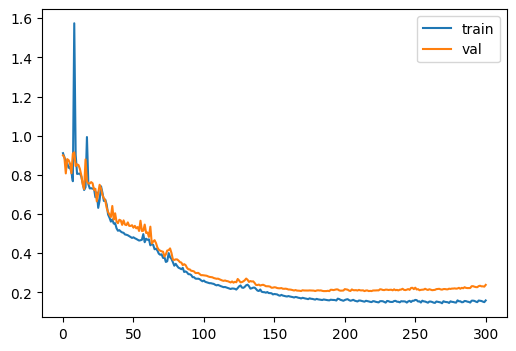

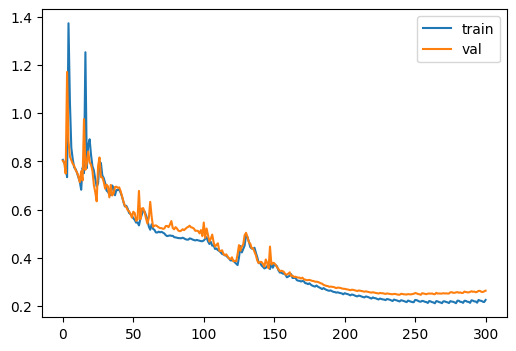

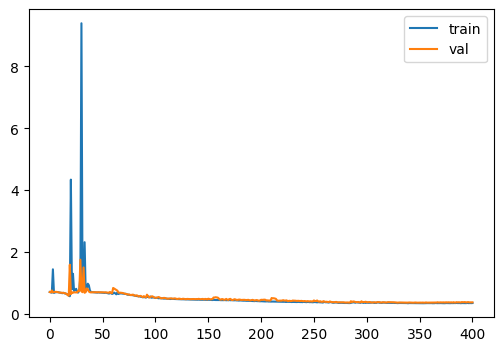

In [ ]:
plot_train_val_loss(gat_stats_hard)
plot_train_val_loss(gat_stats_hard_)
plot_train_val_loss(gat_stats_hard_alpha)


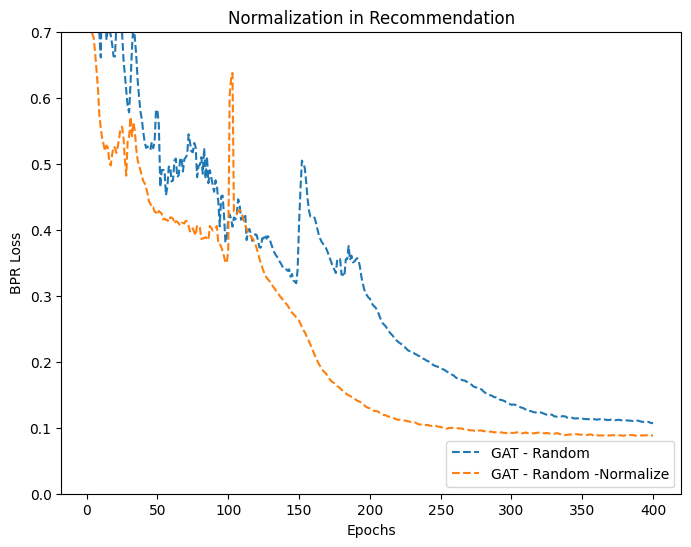

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))

key = "loss"

lgc_loss = pd.Series(detach_loss(gat_stats_random["val"][key])).rolling(3).mean()

gat_loss = pd.Series(detach_loss(gat_stats_random_normalize["val"][key])).rolling(3).mean()

#sage_loss = pd.Series(detach_loss(gat_stats_hard_alpha["val"][key])).rolling(3).mean()

idx = np.arange(0, len(lgc_loss), 1)



colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

ax.plot(idx, lgc_loss, color = colors[0], linestyle = 'dashed', label = "GAT - Random")

ax.plot(idx, gat_loss, color = colors[1], linestyle = 'dashed', label = "GAT - Random -Normalize")

#ax.plot(idx, sage_loss[:301], color = colors[2], linestyle = 'dashed', label = "GAT - alpha")

ax.legend(loc = 'lower right')



ax.set_xlabel("Epochs")

ax.set_ylabel("BPR Loss")

ax.set_title("Normalization in Recommendation")

ax.set_ylim(0, 0.7)

plt.show()

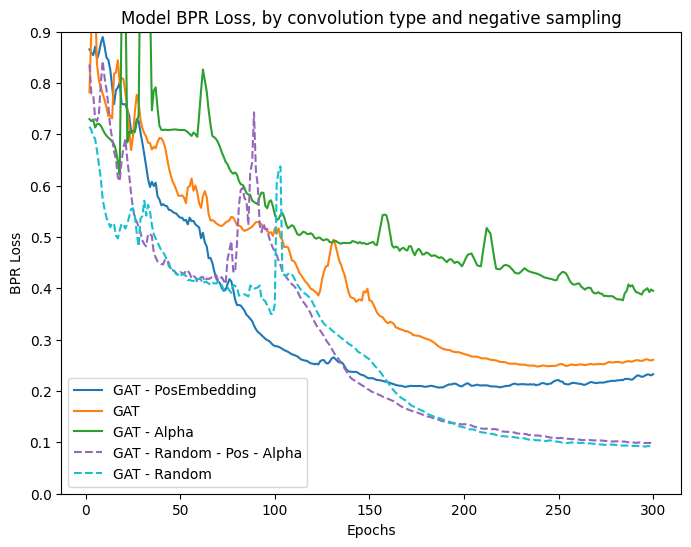

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))

key = "loss"

lgc_loss = pd.Series(detach_loss(gat_stats_hard["val"][key])).rolling(3).mean()

gat_loss = pd.Series(detach_loss(gat_stats_hard_["val"][key])).rolling(3).mean()

sage_loss = pd.Series(detach_loss(gat_stats_hard_alpha["val"][key])).rolling(3).mean()

gat_random_alpha_pos = pd.Series(detach_loss(gat_stats_random_alpha_pos["val"][key])).rolling(3).mean()

gat_random_loss = pd.Series(detach_loss(gat_stats_random_normalize["val"][key])).rolling(3).mean()

idx = np.arange(0, len(lgc_loss), 1)



colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd","#17becf"]

ax.plot(idx, lgc_loss, color = colors[0], label = "GAT - PosEmbedding")

ax.plot(idx, gat_loss, color = colors[1], label = "GAT")

ax.plot(idx, sage_loss[:301], color = colors[2], label = "GAT - Alpha")

ax.plot(idx, gat_random_alpha_pos[:301], color = colors[3], linestyle = 'dashed', label = "GAT - Random - Pos - Alpha")

ax.plot(idx, gat_random_loss[:301], color = colors[4], linestyle = 'dashed', label = "GAT - Random")

ax.legend(loc = 'lower left')



ax.set_xlabel("Epochs")

ax.set_ylabel("BPR Loss")

ax.set_title("Model BPR Loss, by convolution type and negative sampling")

ax.set_ylim(0, 0.9)

plt.show()

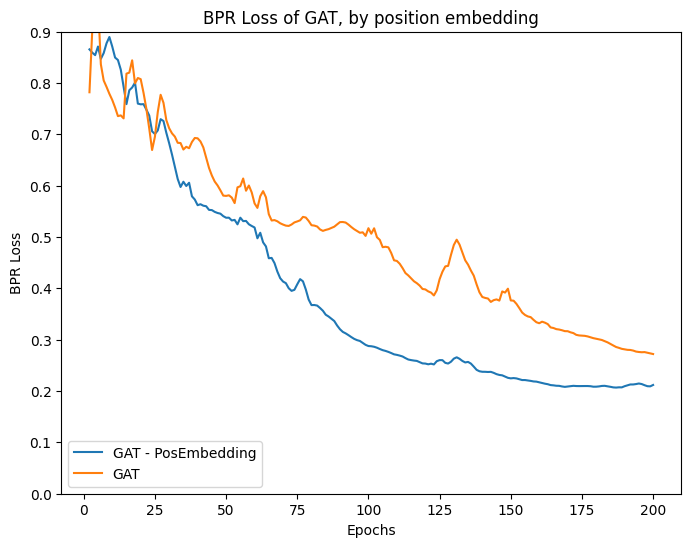

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))

key = "loss"

lgc_loss = pd.Series(detach_loss(gat_stats_hard["val"][key])).rolling(3).mean()

gat_loss = pd.Series(detach_loss(gat_stats_hard_["val"][key])).rolling(3).mean()

idx = np.arange(0, 201, 1)



colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd","#17becf"]

ax.plot(idx, lgc_loss[:201], color = colors[0], label = "GAT - PosEmbedding")

ax.plot(idx, gat_loss[:201], color = colors[1], label = "GAT")


ax.legend(loc = 'lower left')



ax.set_xlabel("Epochs")

ax.set_ylabel("BPR Loss")

ax.set_title("BPR Loss of GAT, by position embedding")

ax.set_ylim(0, 0.9)

plt.show()

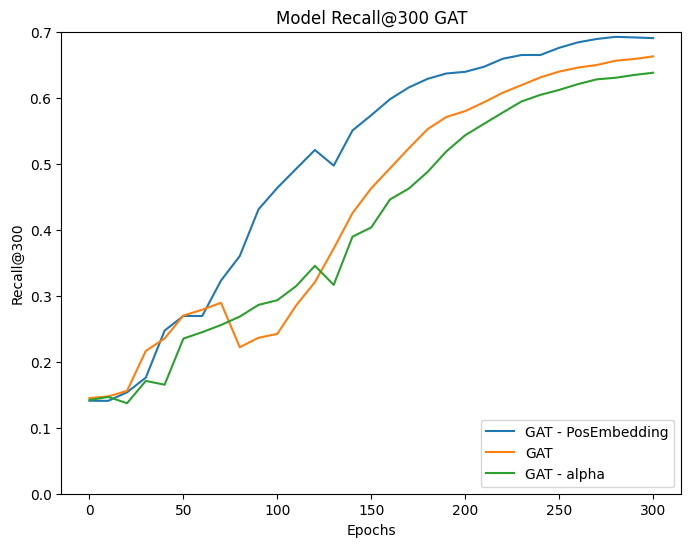

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))

key = "recall"


lgc_recall = gat_stats_hard["val"][key]

gat_recall = gat_stats_hard_["val"][key]

sage_recall = gat_stats_hard_alpha["val"][key]

# increment by 10

idx = np.arange(0, 10 * len(lgc_recall), 10)



colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

ax.plot(idx, lgc_recall, color = colors[0], label = "GAT - PosEmbedding")

ax.plot(idx, lgc_hard_recall[:31], color = colors[1], label = "GAT")

ax.plot(idx, gat_recall[:31], color = colors[2], label = "GAT - alpha")

ax.legend(loc = 'lower right')



ax.set_xlabel("Epochs")

ax.set_ylabel("Recall@300")

ax.set_title("Model Recall@300 GAT")

ax.set_ylim(0, 0.7)

plt.show()

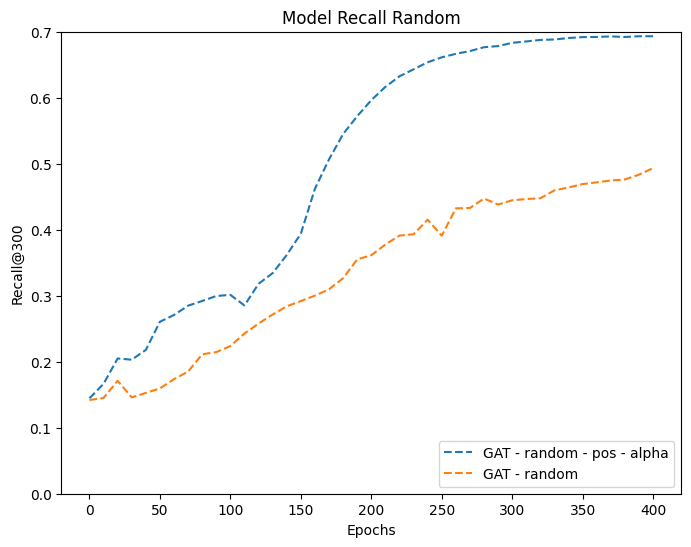

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))

key = "recall"


lgc_hard_recall = gat_stats_random_alpha_pos["val"][key]

gat_hard_recall = gat_stats_random_normalize["val"][key]

# increment by 10

idx = np.arange(0, 10 * len(lgc_hard_recall), 10)



colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

ax.plot(idx, gat_hard_recall, color = colors[0], linestyle = 'dashed', label = "GAT - random - pos - alpha")

ax.plot(idx, sage_recall, color = colors[1], linestyle = 'dashed', label = "GAT - random")

ax.legend(loc = 'lower right')



ax.set_xlabel("Epochs")

ax.set_ylabel("Recall@300")

ax.set_title("Model Recall Random")

ax.set_ylim(0, 0.7)

plt.show()

## Visualizing our results

Now that we've produced models, let's visualize the embeddings of some of our models. Since our embeddings are in 64 dimensions, we use [uniform manifold approximation and projection](https://umap-learn.readthedocs.io/en/latest/) to reduce the embeddings to three dimensions so that we can visualize them. We chose to explore the 30-core SAGEConv model that was trained on 50 data files.

In [ ]:
# Imports specifc to visualizations

import matplotlib.animation as animation

import umap

from IPython import display

from math import floor, ceil

In [ ]:
# Reduce 64-dim embeddings to 3-dim using umap

umap_embs = [] # dimensionally reduced embeddings

umap_embs_negsamp = [] # indicates if index is a hard negative sampling embedding

rand, hard = 0, 1 # enumeration of types of negative sampling

negsamp = ["Random", "Hard"] # used in plot titles

epoch_str = [] # what epoch produced the embeddings



# Directory contianing the selected model embeddings

#model_dir = "model_embeddings/LGCN_SAGE_3_e64_nodes34810"
model_dir = "/kaggle/working/model_embeddings/LGCN_GAT_3_e64_nodes35300_alpha"


for filename in tqdm(sorted(os.listdir(join(os.getcwd(), model_dir)),

                       key=lambda name: int(name[:-3].split('_')[-1]))):

  embs = torch.load(join(os.getcwd(), model_dir, filename), map_location=torch.device('cpu')).detach().cpu().numpy()

  embs = embs[:n_playlists]

  u = umap.UMAP(init='random', random_state=224, n_components=3).fit_transform(embs)

  if 'hard' in filename:

    umap_embs_negsamp.append(1)

  else:

    umap_embs_negsamp.append(0)

  umap_embs.append(u)

  epoch_str.append(filename[:-3].split('_')[-1])

  0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_30/656223696.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs = torch.load(join(os.getcwd(), model_dir, filenam

In [ ]:
# Separate the embeddings dimensions for plotting

n = len(umap_embs)

n_emb = len(umap_embs[0])



def extract_dim(dim):

  """Given a dim index, return just that dim of umap_embs"""

  return [[umap_embs[i][j][dim] for j in range(n_emb)] for i in range(n)]



x = extract_dim(0)

y = extract_dim(1)

z = extract_dim(2)



def compute_min_max(dim, h):

  """Given a dim index and negative sampling type, compute dim limits"""

  dim = [dim[i] for i in range(n) if umap_embs_negsamp[i] == h]

  return floor(min([min(dim[i]) for i in range(len(dim))])), ceil(max([max(dim[i]) for i in range(len(dim))]))

In [ ]:
def plot_embeddings(h, select_idx=None, color=None):

  """

  Given a negative sampling type, plot the playlist embeddings.

  Optional parameters: select_idx, color are the selected

  indices to plot and the associated color mappings

  """

  # Indecies of embeddings of type t (rand, hard)

  idx = [i for i in range(n) if umap_embs_negsamp[i] == h]



  # Set up plot

  fig = plt.figure(figsize = (10, 10))

  subplt = plt.axes(projection ="3d")

  # Initialize the scatter plot

  if (select_idx):

    my_cmap = plt.get_cmap('cividis')

    sct = subplt.scatter([x[idx[0]][i] for i in select_idx],

                          [y[idx[0]][i] for i in select_idx],

                          [z[idx[0]][i] for i in select_idx],

                          alpha = 0.8,

                          c = color,

                          cmap = my_cmap,

                          marker ='o')

  else:

    sct = subplt.scatter(x[idx[0]], y[idx[0]], z[idx[0]],

                          alpha = 0.8, marker ='o')

  # Set axis limit

  subplt.set_xlim(compute_min_max(x, h))

  subplt.set_xlabel('x')

  subplt.set_ylim(compute_min_max(y, h))

  subplt.set_xlabel('y')

  subplt.set_zlim(compute_min_max(z, h))

  subplt.set_xlabel('z')



  # Define animation update funcion

  def update(itr, xa, ya, za, t):

    i = idx[itr]

    subplt.set_title('Embedding Epoch: ' + epoch_str[i] +

                     ", " + negsamp[t] +

                     " Negative Sampling")

    if (select_idx):

      xyz = ([xa[i][j] for j in select_idx],

             [ya[i][j] for j in select_idx],

             [za[i][j] for j in select_idx])

    else:

      xyz = (xa[i], ya[i], za[i])

    sct._offsets3d = xyz

    return sct



  # Create animation

  ani = animation.FuncAnimation(fig, update,

                                fargs=(x, y, z, h),

                                interval=500,

                                save_count=len(idx))

  video = ani.to_html5_video()

  html = display.HTML(video)

  display.display(html)

  plt.close()

Now let's watch the animated video as the playlist embeddings change between epochs! We collected embeddings every few epochs, so the transition between embeddings is not smooth. We first graph the embeddings for the version of the selected model that uses random negative sampling and then for the version that uses hard negative sampling.

In [ ]:
plot_embeddings(rand)

In [ ]:
plot_embeddings(hard)